In [1]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from statsmodels.stats.multitest import fdrcorrection
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm



In [2]:
def run_ols_and_extract(y, X, target):
    """
    Fit OLS y ~ X and return coef, t, p for the target variable (e.g., 'Gender' or 'Age_num'),
    plus partial r = sign(t) * sqrt(t^2/(t^2 + df_resid))
    """
    X = sm.add_constant(X, has_constant="add")
    model = sm.OLS(y, X).fit()
    if target not in model.params.index:
        return np.nan, np.nan, np.nan, np.nan, len(y), model.df_resid
    beta = model.params[target]
    tval = model.tvalues[target]
    pval = model.pvalues[target]
    # Partial correlation from t-stat
    df_resid = model.df_resid
    pr = np.sign(tval) * np.sqrt((tval**2) / (tval**2 + df_resid))
    return beta, tval, pval, pr, len(y), df_resid


In [3]:
# import matplotlib.pyplot as plt

# for var in harm_vars:
#     plt.figure(figsize=(6,4))
#     plt.hist(df.loc[df['Gender']==0, var], bins=30, alpha=0.5, label='Female')
#     plt.hist(df.loc[df['Gender']==1, var], bins=30, alpha=0.5, label='Male')
#     plt.xlabel(var)
#     plt.ylabel("Count")
#     plt.title(f"Histogram of {var} by Gender")
#     plt.legend()
#     plt.tight_layout()
#     plt.show()


Gender differences, now correcting for heart rate and PPG quality:

Trying to get OHBM-ready statistical table:

Using the fixed data, using bins and normalizing to DC before motion regression:

In [4]:
import pandas as pd
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import fdrcorrection

# -------------------------------------------------------------
# Helper functions
# -------------------------------------------------------------
def remove_outliers_iqr(df, col, k=1.5):
    """Remove extreme outliers in a column using the IQR rule."""
    Q1, Q3 = df[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    low, high = Q1 - k * IQR, Q3 + k * IQR
    before = len(df)
    df = df[(df[col].between(low, high))]
    print(f" - {col}: removed {before - len(df)} outliers (k={k})")
    return df


def filter_by_subject_list(df, subject_file):
    """Filter dataframe to include only subjects listed in subject_file."""
    subjects = pd.read_csv(subject_file, header=None)[0].astype(str).tolist()
    df["Subject"] = df["Subject"].astype(str)
    return df[df["Subject"].isin(subjects)]


# -------------------------------------------------------------
# 1. Load datasets
# -------------------------------------------------------------
print("\n--- Loading subject demographics ---")
df = pd.read_csv(r"C:\DocumentsPC\DATA\HCP\unrestricted_cm15_4_22_2025_11_11_54.csv")

# Convert categorical to numeric
df["Gender"] = df["Gender"].map({"F": 0, "M": 1})
df["Age_num"] = df["Age"].map({"22-25": 23.5, "26-30": 28.0, "31-35": 33.0})

# Restrict to available subjects
df = filter_by_subject_list(df, r"D:\HCP_vessel_files\subjects.txt")
print(f"✅ Subjects after selection: {len(df)}")

original_df = df.copy()


print("\n--- Loading harmonic / vessel R² data ---")
# harm = pd.read_csv(r"D:\hcp_processed\moreharm1numR2G.csv")
# harm = pd.read_csv(r"D:\hcp_processed\Harm1numBinR2G.csv") # too many outliers when normalized to 1st harmonic, almost half the data
harm = pd.read_csv(r"D:\hcp_processed\Harm1numBinR2GDC.csv") # all harmonics normalized to DC
# harm_dc = pd.read_csv(r"D:\hcp_processed\HDVessR2Gp1ROI.csv") # NEED TO FIX THIS ONE, WRONG 

# compute harmonic distortion: mean(A2A1**2 to A6A1**2) / A1DC**2 for each subject: Equation 1 from Milkovish et al. 2022
hd_cols = ["A2A1", "A3A1", "A4A1", "A5A1", "A6A1"]
harm["HD"] = (harm[hd_cols]**2).mean(axis=1) / (harm["A1DC"]**2) # Compute HD using raw values (before normalization)

# Normalize to A1:
cols_to_norm = ["A2A1", "A3A1", "A4A1", "A5A1", "A6A1"]
# divide each of those columns by A1DC
harm[cols_to_norm] = harm[cols_to_norm].div(harm["A1DC"], axis=0)


harm["Subject"] = harm["Subject"].astype(str)

# compute harmonic distortion: (or solve for in voxel-wise in new file?) 

# harm["HDvessel"] = harm_dc["HDvessel"]
# harm["VoxelsInMask"] = harm_dc["VoxelsInMask"]

# Merge with demographics
df = df.merge(harm, on="Subject", how="inner")
print(f"✅ Merged dataset size: {len(df)} subjects")

print("\n--- Adding heart rate ---")
hr = pd.read_csv(r"D:\hcp_processed\heart_rate_summary.csv")
hr["SubjectID"] = hr["SubjectID"].astype(str)
df = df.merge(hr[["SubjectID", "HeartRate_BPM"]], left_on="Subject", right_on="SubjectID", how="left")
print(f"✅ Heart rate available for {df['HeartRate_BPM'].notna().sum()} subjects")

print("\n--- Motion exclusion ---")
fd = pd.read_csv(r"D:\hcp_processed\fd_summary.csv")
fd["subjectid"] = fd["subjectid"].astype(str)
df = df.merge(fd[["subjectid", "exclude"]], left_on="Subject", right_on="subjectid", how="left")

before = len(df)
df = df[df["exclude"] != True]
print(f"✅ Motion exclusion: removed {before - len(df)} subjects (kept {len(df)})")

# -------------------------------------------------------------
# 2. Outlier filtering
# -------------------------------------------------------------
print("\n--- Removing outliers ---")

# Remove extreme heart rate values
df = remove_outliers_iqr(df, "HeartRate_BPM", k=3)

# # Reliability filter
# print(f"\nVoxelsInMask ≥ 500: {df[df['VoxelsInMask'] >= 500].shape[0]} subjects kept")
# df = df[df["VoxelsInMask"] >= 500]

# HDvessel outliers
k_metric = 3 # 3 # 2.5 # 2 looks good
# 1.5 makes plots look lees outlier heavy 
# 3 makes A2A1 significant w/ small effect size # 5 seemed to work, but removes a lot of subjects 
# df = remove_outliers_iqr(df, "HDvessel", k=k_metric)

# Harmonic outliers
for col in ["A1DC", "A2A1", "A3A1", "A4A1", "A5A1", "A6A1"]:
    df = remove_outliers_iqr(df, col, k=k_metric)

print(f"\n✅ Final dataset size: {len(df)} subjects")


# -------------------------------------------------------------
# 3. HR gender difference test
# -------------------------------------------------------------
male = df.loc[df["Gender"] == 1, "HeartRate_BPM"]
female = df.loc[df["Gender"] == 0, "HeartRate_BPM"]
t, p = ttest_ind(male, female, equal_var=False)

print("\n--- Heart Rate (Male vs Female) ---")
print(f" Male HR  : {male.mean():.2f} bpm")
print(f" Female HR: {female.mean():.2f} bpm")
print(f" t = {t:.2f}, p = {p:.4f}")


# -------------------------------------------------------------
# 4. OLS Regression: Does Gender predict vascular metrics?
# -------------------------------------------------------------
print("\n--- Running regression: controlling for Age + Heart Rate ---")

# harm_vars = ["A1DC","A2A1","A3A1","A4A1","A5A1","A6A1"]
harm_vars = ["A1DC","A2A1","A3A1","A4A1","A5A1","A6A1","HD"]

results = []

targets = ["Gender"]
# targets = ["Gender", "Age_num"]
# targets = ["Gender", "Age_num", "CogFluidComp_Unadj", "CogCrystalComp_Unadj", "ListSort_Unadj"]

for outcome in harm_vars:
    for target in targets:
        predictors = [target, "Age_num", "HeartRate_BPM"]
        # predictors = [target, "HeartRate_BPM"]

        # Build model dataset
        # tmp = df[[outcome, "Gender", "Age_num", "HeartRate_BPM"]].dropna()
        # y = tmp[outcome].astype(float)
        # X = tmp[["Gender", "Age_num", "HeartRate_BPM"]].astype(float)

        tmp = df[[outcome] + predictors].dropna()
        y = tmp[outcome].astype(float)
        X = tmp[predictors].astype(float)

        # Run regression focusing on selected predictor
        beta, t, p, partial_r, n, dfres = run_ols_and_extract(y, X, target=target)

        # Store results, including the predictor name
        results.append([outcome, target, beta, partial_r, t, p, n])

res = pd.DataFrame(results, columns=["Outcome", "Predictor", "beta", "partial_r", "t", "p", "n"])
res["p_FDR"] = fdrcorrection(res["p"], alpha=0.05)[1]

print("\n=== Regression results (FDR corrected) ===")
print(res.sort_values("p_FDR").to_string(index=False))


# the next cell is using the wrong data? why?
df_clean = df.copy()
res_clean = res.copy()

assert set(df["Subject"]) == set(df_clean["Subject"]), "Mismatch in subjects between df and df_clean"

# save all of the subjects used for in the analysis, so we can use it later for maps:


# # Convert to dataframe
# res = pd.DataFrame(results, columns=["Outcome", "Predictor", "beta", "partial_r", "t", "p", "n"])
# # FDR correction
# res["p_FDR"] = fdrcorrection(res["p"], alpha=0.05)[1]
# print("\n=== Regression results (Age + HR controlled) ===")
# print(res.sort_values("p_FDR").to_string(index=False))


# res = pd.DataFrame(results, columns=["Outcome", "beta", "partial_r", "t", "p", "n"])
# res["p_FDR"] = fdrcorrection(res["p"], alpha=0.05)[1]
# print(f"\n=== Regression results: {target} → Vascular metrics (Age + HR corrected) ===")
# print(res.sort_values("p_FDR").to_string(index=False))



--- Loading subject demographics ---
✅ Subjects after selection: 190

--- Loading harmonic / vessel R² data ---
✅ Merged dataset size: 190 subjects

--- Adding heart rate ---
✅ Heart rate available for 190 subjects

--- Motion exclusion ---
✅ Motion exclusion: removed 10 subjects (kept 180)

--- Removing outliers ---
 - HeartRate_BPM: removed 0 outliers (k=3)
 - A1DC: removed 0 outliers (k=3)
 - A2A1: removed 15 outliers (k=3)
 - A3A1: removed 3 outliers (k=3)
 - A4A1: removed 1 outliers (k=3)
 - A5A1: removed 1 outliers (k=3)
 - A6A1: removed 0 outliers (k=3)

✅ Final dataset size: 160 subjects

--- Heart Rate (Male vs Female) ---
 Male HR  : 63.63 bpm
 Female HR: 68.04 bpm
 t = -2.70, p = 0.0078

--- Running regression: controlling for Age + Heart Rate ---

=== Regression results (FDR corrected) ===
Outcome Predictor      beta  partial_r         t            p   n        p_FDR
   A3A1    Gender  0.053869   0.442579  6.144629 6.484747e-09 159 4.539323e-08
   A5A1    Gender  0.024651 

In [5]:
# import pandas as pd, numpy as np

# def df_sig(df, cols=None):
#     # fast fingerprint of rows/cols & values
#     if cols is None:
#         cols = [c for c in df.columns if c != "GenderLabel"]
#     return (len(df), tuple(sorted(cols)), int(pd.util.hash_pandas_object(df[cols], index=True).sum()))

# print(">>> BEFORE reassignment")
# try:
#     print("df_clean sig:", df_sig(df_clean))
#     print("res_clean rows:", len(res_clean))
# except NameError:
#     raise RuntimeError("df_clean/res_clean not defined in kernel. Re-run the previous cell.")

# try:
#     print("df (current) sig:", df_sig(df))
# except Exception:
#     print("df (current) not defined yet")

# # use deep copies to avoid in-place mutation feeding back
# df = df_clean.copy(deep=True)
# res = res_clean.copy(deep=True)

# print(">>> AFTER reassignment")
# print("df (used for plotting) sig:", df_sig(df))
# print("Subjects in df:", df["Subject"].nunique())


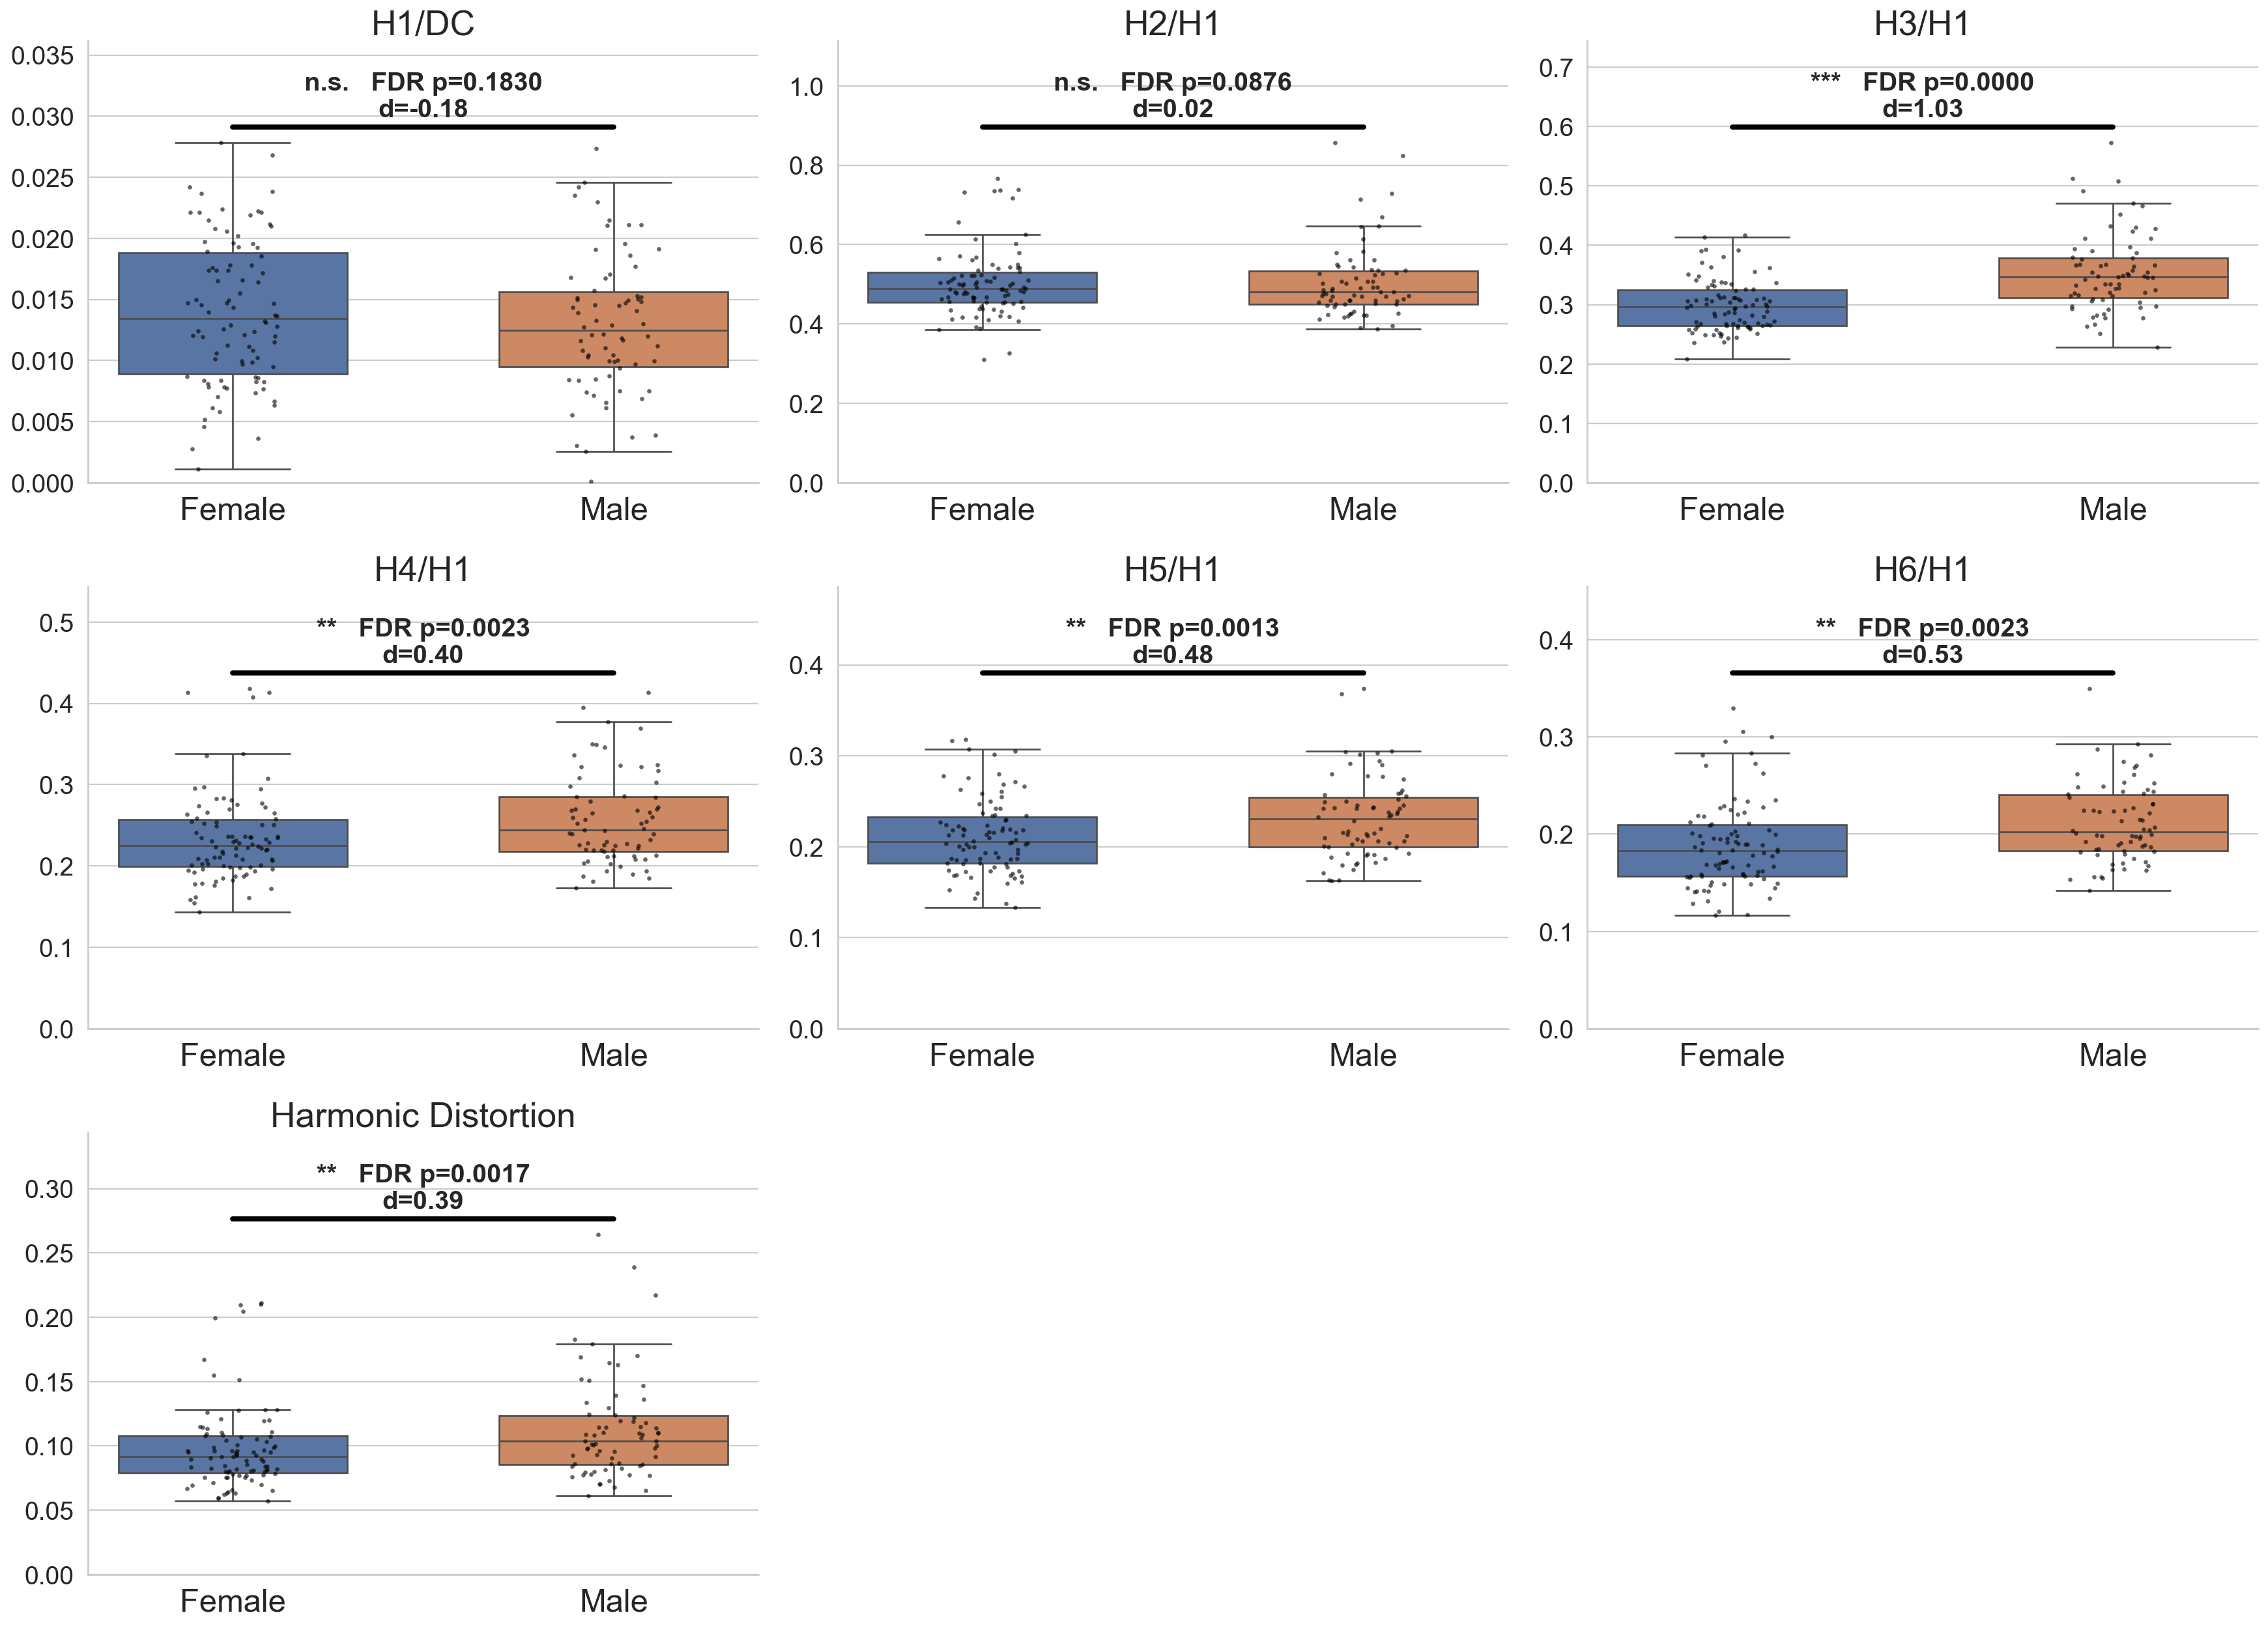

In [26]:
# why won't it use the data from previous cell?!
df = df_clean
res = res_clean

###
sns.set_theme(style="whitegrid", font_scale=1.6)   # <-- larger fonts
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["figure.dpi"] = 160                   # <-- sharper



import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Renaming dictionary for publication-quality labels
label_map = {
    "A1DC": "H1/DC",
    "A2A1": "H2/H1",
    "A3A1": "H3/H1",
    "A4A1": "H4/H1",
    "A5A1": "H5/H1",
    "A6A1": "H6/H1",
    "HD": "Harmonic Distortion"
}

# ✅ NEW: Function to compute Cohen's d
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    pooled_sd = np.sqrt(((nx - 1)*np.var(x, ddof=1) + (ny - 1)*np.var(y, ddof=1)) / (nx + ny - 2))
    return (np.mean(y) - np.mean(x)) / pooled_sd

# sns.set_theme(style="ticks", font_scale=1.6)

metrics = ["A1DC","A2A1","A3A1","A4A1","A5A1","A6A1","HD"]
df["GenderLabel"] = df["Gender"].map({0: "Female", 1: "Male"})
# pvals = {row["Outcome"]: row["p_FDR"] for _, row in res.iterrows()}
# Use the rows for Gender only
pvals = (
    res.loc[res["Predictor"] == "Gender"]
       .set_index("Outcome")["p_FDR"]
       .to_dict()
)

####### debugging #########
# # print(f"pvals {pvals}")
# print(res["Predictor"].value_counts())
# print(res.groupby(["Outcome","Predictor"]).size())
# for m in ["A1DC","A2A1","A3A1","A4A1","A5A1","A6A1","HD"]:
#     print(m, pvals.get(m))
# for metric in ["A1DC","A2A1","A3A1","A4A1","A5A1","A6A1","HD"]:
#     tmp = df[[metric, "Gender", "Age_num", "HeartRate_BPM"]].dropna()
#     print(metric, "   regression_n =", len(tmp), "   plotted_n =", df[metric].notna().sum())

#################################

def sig_stars(p):
    if p < 0.001: return "***"
    elif p < 0.01: return "**"
    elif p < 0.05: return "*"
    return "n.s."

fig, axes = plt.subplots(3, 3, figsize=(22, 16))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    ax = axes[i]
    p = pvals.get(metric, np.nan)
    stars = sig_stars(p)

    # ✅ fix seaborn warning — assign hue instead of palette only
    sns.boxplot(
        data=df, x="GenderLabel", y=metric, hue="GenderLabel", ax=ax,
        palette=["#4C72B0", "#DD8452"], linewidth=1.2, width=0.6, showfliers=False,
        dodge=False, legend=False  # <-- no legend
    )
    sns.stripplot(
        data=df, x="GenderLabel", y=metric, ax=ax,
        color="black", size=3, jitter=0.12, alpha=0.6
    )
    # # Compute effect size (female vs male)
    # female_vals = df[df["GenderLabel"] == "Female"][metric]
    # male_vals   = df[df["GenderLabel"] == "Male"][metric]
    tmp = df[[metric, "Gender", "Age_num", "HeartRate_BPM"]].dropna()
    female_vals = tmp[tmp["Gender"] == 0][metric]
    male_vals   = tmp[tmp["Gender"] == 1][metric]

    d = cohens_d(female_vals, male_vals)

    # Expand y-axis so text fits
    # y_min = df[metric].min()
    y_min = 0
    y_max = df[metric].max()
    # pad = (y_max - y_min) * 0.40
    pad = (y_max - y_min) * 0.30
    ax.set_ylim(y_min, y_max + pad)

    # # Plot significance bar
    # y_bar = y_max + pad * 0.10
    # ax.plot([0, 1], [y_bar, y_bar], lw=1.6, color="black")
    # # ✅ show both p-value and effect size
    # ax.text(
    #     0.5, y_bar + pad * 0.08,
    #     f"{stars}  FDR p={p:.4f}\nd={d:.2f}",
    #     ha="center", fontsize=14
    # )
    # Thicker significance bar + bold text
    y_bar = y_max + pad * 0.15
    ax.plot([0, 1], [y_bar, y_bar], lw=3.5, color="black")

    ax.annotate(
        f"{stars}   FDR p={p:.4f}\nd={d:.2f}",
        xy=(0.5, y_bar),
        xytext=(0.5, y_bar + pad * 0.10),
        ha="center",
        fontsize=18, fontweight="bold"
    )

    # ax.set_title(metric, fontsize=18, pad=14)
    ax.set_title(label_map.get(metric, metric), fontsize=24, pad=4) # 18 fontsize, 14 pad
    ax.set_xlabel("")
    ax.tick_params(axis='x', labelsize=22, width=2)
    ax.set_ylabel("")

# Remove unused panels
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# fig.suptitle(
#     "Vascular Harmonic Metrics by Gender (cleaned, outliers removed)\n"
#     "Box + whisker + datapoints + FDR significance + Cohen's d",
#     fontsize=22, y=1.02
# )

# ax.text(-0.25, 1.05, f"{chr(65+i)}.", transform=ax.transAxes,
#         fontsize=18, fontweight="bold")

plt.tight_layout()
plt.show()


In [7]:
# Get all of the subjects that were excluded from analysis with these parameters:
# original_df 
# keep only rows with all needed values for regression
final_df = df.dropna(subset=["Gender", "Age_num", "HeartRate_BPM"])

# see subjects in orginal_df that are not in df, then save that information so I can loop through later and not have those subjects:

final_df = df.dropna(subset=["Gender", "Age_num", "HeartRate_BPM"] + harm_vars)

excluded_subjects = set(original_df["Subject"]) - set(final_df["Subject"])
excluded_subjects = list(excluded_subjects)

print("Total excluded:", len(excluded_subjects))

pd.DataFrame({"Subject": excluded_subjects}).to_csv(
    r"D:\hcp_processed\excluded_subjects3.csv", index=False
)


Total excluded: 31
